# Importação dos dados

In [26]:
!pip install xgboost

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
path = Path(os.getcwd())
path_parent = path.parent.absolute()
os.chdir(path_parent)

In [27]:
df = pd.read_csv(r'data\sales_data.csv', index_col = 0)
X_train = pd.read_csv('data\processed\pred_train_data.csv')
X_test = pd.read_csv('data\processed\pred_test_data.csv')

# Initial Profilling

In [7]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Sales Data")

In [10]:
profile.to_file('sales_data_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 40.70it/s]


# Dependencia da Hotmart com maiores produtores

1- Trazer essas informações para um Dashboard interativo

2- Fazer relação com distribuições de caudas longas 80/20

3- Mostrar relação dos que possuem um grande volume de vendas com a importância deles no lucro da HotMart

4- Mostrar relação dos que possuem um valor alto de vendas com a importância deles no lucro da Hotmart

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['purchase_transformed'] = scaler.fit_transform(df[['purchase_value']])
sum_of_values = df.groupby(['producer_id']).agg(valor_total = ('purchase_value', 'sum'),
                                                valor_transformed = ('purchase_transformed', 'sum'),
                                                count = ('purchase_transformed', 'count')).reset_index()
labels_cut = ['baixissimo_volume', 'baixo_volume', 'medio_volume', 'alto_volume', 'altissimo_volume']
sum_of_values['total_qcut'] = pd.qcut(sum_of_values['valor_total'], q=5, labels=labels_cut)
sum_of_values['transformed_qcut'] = pd.qcut(sum_of_values['valor_transformed'], q=5, labels=labels_cut)

In [7]:
import plotly.graph_objects as go
purchase = 'purchase_transformed'
product_revenue = df.groupby(['product_id']).agg(revenue_product=(purchase, 'sum')).sort_values(by='revenue_product')
product_revenue['cumulative_revenue'] = product_revenue['revenue_product'].cumsum()
product_revenue['percentile'] = pd.qcut(product_revenue['revenue_product'], q=100, labels=False, duplicates='drop')
# Group the DataFrame by percentile and calculate the cumulative sum of revenue for each percentile
df_percentile = product_revenue.groupby('percentile')['cumulative_revenue'].max().reset_index()
df_percentile['percentage_revenue'] = df_percentile['cumulative_revenue']/product_revenue['cumulative_revenue'].max()

# Create the plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df_percentile['percentile'],
    y=df_percentile['percentage_revenue'],
    mode='lines',
    line=dict(color='royalblue'),
    name='Cumulative Revenue'
))
fig.update_layout(
    title='Cumulative Revenue of Producers by Percentile',
    xaxis_title='Percentile',
    yaxis_title='Cumulative Revenue',
)

# Show the figure
fig.show()

In [8]:
def plot_cumulative_revenue(df, purchase, threshold):
    # Your data processing code
    product_revenue = df.groupby(['product_id']).agg(revenue_product=(purchase, 'sum')).sort_values(by='revenue_product')
    product_revenue['cumulative_revenue'] = product_revenue['revenue_product'].cumsum()
    product_revenue['percentile'] = pd.qcut(product_revenue['revenue_product'], q=101, labels=False, duplicates='drop')
    df_percentile = product_revenue.groupby('percentile')['cumulative_revenue'].max().reset_index()
    df_percentile['percentage_revenue'] = df_percentile['cumulative_revenue'] / product_revenue['cumulative_revenue'].max()

    # Create the plot
    fig = go.Figure()
    blue_line = df_percentile[df_percentile['percentile'] <= threshold]
    fig.add_trace(go.Scatter(
        x=blue_line['percentile'],
        y=blue_line['percentage_revenue'],
        mode='lines',
        line=dict(color='gray', width=2),
        name='Outros produtos'
    ))
    hotmart_line = df_percentile[df_percentile['percentile'] >= threshold]
    fig.add_trace(go.Scatter(
        x=hotmart_line['percentile'],
        y=hotmart_line['percentage_revenue'],
        mode='lines',
        line=dict(color='#ff4e1a', width=2),
        name='Maiores produtos'
    ))

    fig.update_layout(
        xaxis_title='Percentil produtos por faturamento',
        yaxis_title='Percentual do faturamento',
        plot_bgcolor='rgba(0,0,0,0)',  # Remove background color
    )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False,
                     )
    # Show the figure
    fig.show()

purchase = 'purchase_transformed'
threshold = 90

plot_cumulative_revenue(df, purchase, threshold)


In [18]:
df.columns

Index(['purchase_id', 'product_id', 'affiliate_id', 'producer_id', 'buyer_id',
       'purchase_date', 'product_creation_date', 'product_category',
       'product_niche', 'purchase_value', 'affiliate_commission_percentual',
       'purchase_device', 'purchase_origin', 'is_origin_page_social_network',
       'Venda', 'purchase_transformed'],
      dtype='object')

In [23]:
def plot_revenue_percentile(df, percentile_threshold):
    # Calculate the cumulative revenue and percentile
    purchase = 'purchase_transformed'
    product_revenue = df.groupby('product_id')[purchase].sum().sort_values()
    product_revenue = product_revenue.reset_index()
    product_revenue['percentile'] = pd.qcut(product_revenue[purchase], q=100, labels=False, duplicates='drop')
    
    # Determine high-sellers and low-sellers based on percentile threshold
    high_sellers = product_revenue[product_revenue['percentile'] >= percentile_threshold]
    low_sellers = product_revenue[product_revenue['percentile'] < percentile_threshold]
    
    # Calculate percentage contribution of each group
    total_revenue = product_revenue[purchase].sum()
    high_sellers_percentage = (high_sellers[purchase].sum() / total_revenue)*100
    low_sellers_percentage = (low_sellers[purchase].sum() / total_revenue)*100
    bar_width = 0.6
    # Create the bar plots for high-sellers and low-sellers
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=['Maiores Produtos'],
        y=[high_sellers_percentage],
        name='Maiores Produtos',
        marker=dict(color='#ff4e1a'),
        width=bar_width,  # Reduce bar width
    ))
    fig.add_trace(go.Bar(
        x=['Outros Produtos'],
        y=[low_sellers_percentage],
        name='Outros Produtos',
        marker=dict(color='lightgray'),
        width=bar_width,  # Reduce bar width
    ))
    
    # Set the layout
    fig.update_layout(
        showlegend=False,  # Remove legend
        plot_bgcolor='rgba(0,0,0,0)',  # Remove background color
        xaxis=dict(
            showgrid=False,  # Remove x-axis gridlines
            tickfont=dict(size=18),  # Increase x-axis tick font size
        ),
        yaxis=dict(
            range=[0, 100], # Set y-axis range from 0 to 1
            showgrid=False,  # Remove y-axis gridlines
            tickfont=dict(size=18),  # Increase y-axis tick font size
        ),
    )
    
    # Show the figure
    fig.show()
    
# Assuming you have a DataFrame called 'df' with 'product_id' and 'purchase_transformed' columns
plot_revenue_percentile(df, percentile_threshold=90)

In [5]:
hotmart_maiores_produtores = df.merge(sum_of_values, how='inner', left_on='producer_id', right_on='producer_id')

In [84]:
import plotly.express as px
top_20_value = sum_of_values[sum_of_values['valor_transformed'] > np.percentile(sum_of_values['valor_transformed'], 80)]['producer_id']
hotmart_maiores_produtores[hotmart_maiores_produtores['producer_id'].isin(top_20_value)]['purchase_transformed'].sum()/hotmart_maiores_produtores['purchase_transformed'].sum()

top_20_value = sum_of_values[sum_of_values['count'] > np.percentile(sum_of_values['count'], 80)]['producer_id']
hotmart_maiores_produtores[hotmart_maiores_produtores['producer_id'].isin(top_20_value)]['purchase_transformed'].sum()/hotmart_maiores_produtores['purchase_transformed'].sum()



0.9437371612326654

# Quais características impactam no sucesso de um produto (Quem são esses maiores produtores)

Adicionais a serem trazidos na análise

1- Verificar sazonalidade de tipos de produto

1.1 - Dias da semana com maior volume de compras

1.2 - Horários com maior volume de compras

2- Fazer a feature importance por tipo de produto

3- Fazer modelo que prediz quantas compras vão ser realizadas a um dado produto

4- Fazer página do Dash com um conjunto de opções e a partir disso medir/metrificar número de compras de produto ou total acumulado por produto

5- Fazer primeiro a previsão inicial para depois seguir para Feature Engineering

6- Fazer análise mais aprofundada de purchase_device, purchase_origin, is_origin_page_social_network

In [52]:
from sklearn.base import BaseEstimator, TransformerMixin
class ColumnOtherCategory(BaseEstimator, TransformerMixin):
    def __init__(self, column, threshold):
        self.column = column
        self.threshold = threshold
        self.high_frequency_values = None
    
    def fit(self, X, y=None):
        value_counts = X[self.column].value_counts()
        self.high_frequency_values = value_counts[value_counts > self.threshold].index
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.column] = X_copy[self.column].apply(lambda x: x if x in self.high_frequency_values else 'Other')
        return X_copy

In [12]:
X, y = df.drop(columns=['purchase_transformed']), df['purchase_transformed']

In [19]:
n_affiliates = df[['product_id', 'affiliate_id']].groupby('product_id').agg(n_affiliate = ('affiliate_id', 'nunique'))
n_affiliates[n_affiliates['n_affiliate'] > 10].sort_values(by='n_affiliate')

,n_affiliate
product_id,
189801,11
118670,11
116882,11
111462,11
180016,11
...,...
180874,550
143983,602
18399,741


In [4]:
df = df[['product_id', 'affiliate_id', 'producer_id', 'buyer_id', 'purchase_date', 
    'product_creation_date', 'product_category', 'product_niche', 'purchase_value', 
    'affiliate_commission_percentual', 'purchase_device', 'purchase_origin', 
    'is_origin_page_social_network', 'purchase_transformed']]

In [51]:
prod_price = df.groupby('product_id').agg(mean_price = ('purchase_transformed', 'mean'),
                            std_price = ('purchase_transformed', 'std'),
                            n_prices = ('purchase_transformed', 'nunique'))
prod_price[prod_price['n_prices'] > 10]

,mean_price,std_price,n_prices
product_id,,,
748,0.001538,0.000089,46
2195,0.000918,0.000051,11
2350,0.003004,0.000181,32
2869,0.001543,0.000145,16
4143,0.001480,0.000176,11
...,...,...,...
239080,0.005321,0.001840,12
239141,0.006054,0.001140,19
239279,0.002331,0.000777,11


In [ ]:
columns = ['product_id', 'affiliate_id', 'producer_id', 'product_category', 'product_niche',
           'purchase_device', 'purchase_origin', 'is_origin_page_social_network']
for column in columns:
    df[column] = df[column].astype(str)

df.groupby(by=['product_id', 'affiliate_id', 'producer_id', 'product_category', 'product_niche',
               'purchase_device', 'purchase_origin', 'is_origin_page_social_network']).agg(
                   num_of_sales = ('buyer_id', 'count'),
                   num_of_buyers = ('buyer_id', 'nunique'),
                   mean_price = ('purchase_transformed', 'mean'),
                   total_purchase = ('purchase_transformed', 'sum'))

## Impacto do Affiliate_id no total de vendas
1- Existem mais affilates do que produtores, alguns produtores também são afiliates de outros produtores

In [5]:
df['have_affiliate'] = True
df.loc[df['affiliate_id'] == df['producer_id'], 'have_affiliate'] = False

def feature_eng(df, filter_with_few_products = False):
    df = affiliate_feature_eng(df, filter_with_few_products)
    df = producer_feature_eng(df, filter_with_few_products)
    df = product_creation_date_eng(df)
    df = repurchasable_eng(df)
    return df

def affiliate_feature_eng(df, filter_with_few_products = False):
    affiliate_n_prod = df.groupby(['affiliate_id', 'product_id']).agg(
                                                    total_vendas=('purchase_transformed', 'sum'),
                                                    count_vendas=('purchase_transformed', 'count')).reset_index()
    affiliate_n_prod = affiliate_n_prod.groupby('affiliate_id').agg(
                                                    n_prod_affiliate=('product_id', 'nunique'),
                                                    count_vendas_affiliate=('count_vendas', 'sum'),
                                                    total_vendas_affiliate = ('total_vendas', 'sum'),
                                                    media_vendas_produtos_affiliate =('total_vendas', 'mean'))
    if filter_with_few_products:
        affiliate_n_prod = affiliate_n_prod[(affiliate_n_prod['n_prod_affiliate'] > 5)]
    df = df.merge(affiliate_n_prod, how = 'left', on=['affiliate_id'])
    return df.drop(columns=['affiliate_id'])

def producer_feature_eng(df, filter_with_few_products = False):
    producer_feat = df.groupby(['producer_id', 'product_id']).agg(
                                                    total_vendas=('purchase_transformed', 'sum'),
                                                    count_vendas=('purchase_transformed', 'count')).reset_index()
    producer_feat = producer_feat.groupby('producer_id').agg(
                                                    n_prod_producer=('product_id', 'nunique'),
                                                    count_vendas_producer=('count_vendas', 'sum'),
                                                    total_vendas_producer = ('total_vendas', 'sum'),
                                                    media_vendas_produtos_producer =('total_vendas', 'mean'))
    if filter_with_few_products:
        producer_feat = producer_feat[(producer_feat['n_prod_producer'] > 5)]
    df = df.merge(producer_feat, how = 'left', on=['producer_id'])
    return df.drop(columns=['producer_id'])

def product_creation_date_eng(df):
    from datetime import datetime
    last_purchase = datetime(2016, 6, 30)
    df['product_creation_date'] = pd.to_datetime(df['product_creation_date'])
    df['years_since_creation'] = last_purchase.year - df['product_creation_date'].dt.year
    df['months_since_creation'] = df['years_since_creation']*12 + (last_purchase.month - df['product_creation_date'].dt.month)
    return df.drop(columns=['product_creation_date'])

def repurchasable_eng(df):

    buyer_d = df.groupby(['product_id', 'buyer_id']).agg(count_purchases = ('buyer_id', 'count')).reset_index()
    buyer_d = buyer_d.groupby(['product_id',]).agg(count_purchases = ('count_purchases', 'sum'),
                                                count_buyers = ('buyer_id','nunique'))
    buyer_d = buyer_d[buyer_d['count_buyers']*1.1 < buyer_d['count_purchases']].reset_index()
    buyer_d['repurchasable'] = True
    df = df.merge(buyer_d[['product_id', 'repurchasable']], how='left', on=['product_id'])
    df['repurchasable'] = df['repurchasable'].fillna(False)
    return df.drop(columns=['buyer_id'])

#df_test = affiliate_feature_eng(df)
#df_test = producer_feature_eng(df)
#df_test = product_creation_date_eng(df)

In [133]:
['affiliate_commission_percentual', 'purchase_device', 'purchase_origin', 
    'is_origin_page_social_network', 'purchase_transformed']

def product_category_eng(df, column):
    #product_category, product_niche
    features = df.groupby(['product_id', column]).agg(
        total_sell = ('purchased_transformed', 'sum'),
        volume_sell = ('purchased_transformed', 'count'),
        num_buyers = ('buyer_id', 'nunique'),
    )

    features = features.groupby(column).agg(
        total_prod = ('product_id', 'count'),
        total_sell = ('total_sell', 'sum'),
        mean_sell = ('total_sell', 'mean'),
        std_sell = ('total_sell', 'std'),
        total_volume = ('volume_sell', 'sum'),
        mean_volume = ('volume_sell', 'mean'),
        std_volume = ('volume_sell', 'std'),
        total_buyers = ('num_buyers', 'sum'),
        mean_buyers = ('num_buyers', 'mean'),
        std_buyers = ('num_buyers', 'std')
    ).reset_index()

    df = df.merge(df, features, on=[column], how='left')
    return df

features = df.groupby(['product_id', column]).agg(
    total_sell = ('purchased_transformed', 'sum'),
    volume_sell = ('purchased_transformed', 'count'),
    num_buyers = ('buyer_id', 'nunique'),
)

features = features.groupby(column).agg(
    total_prod = ('product_id', 'count'),
    total_sell = ('total_sell', 'sum'),
    mean_sell = ('total_sell', 'mean'),
    std_sell = ('total_sell', 'std'),
    total_volume = ('volume_sell', 'sum'),
    mean_volume = ('volume_sell', 'mean'),
    std_volume = ('volume_sell', 'std'),
    total_buyers = ('num_buyers', 'sum'),
    mean_buyers = ('num_buyers', 'mean'),
    std_buyers = ('num_buyers', 'std')
).reset_index()

0                  Video
1                Podcast
2                Podcast
3                Podcast
4                Podcast
               ...      
1599823    Phisical book
1599824    Phisical book
1599825    Phisical book
1599826    Phisical book
1599827    Phisical book
Name: product_category, Length: 1599828, dtype: object

### Purchase_transformed

In [7]:
aggfunc = {
    'purchase_transformed': ['sum', 'count'],
    'buyer_id': 'nunique'
    }
pivot_table = df.pivot_table(values=['purchase_transformed', 'buyer_id'], index='product_id', columns='purchase_device', aggfunc=aggfunc)
new_columns = []
for col in pivot_table.columns:
    if (col[0] == 'buyer_id') and (col[1] == 'nunique'):
        new_columns.append(f'num_buyers_{col[2]}')
    if (col[0] == 'purchase_transformed') and (col[1] == 'count'):
        new_columns.append(f'vollume_sell_{col[2]}')
    if (col[0] == 'purchase_transformed') and (col[1] == 'sum'):
        new_columns.append(f'total_sell_{col[2]}')
pivot_table.columns = new_columns
pivot_table = pivot_table.reset_index().fillna(0)

In [11]:
pivot_table

,product_id,num_buyers_Cellphone,num_buyers_Desktop,num_buyers_Smart TV,num_buyers_Tablet,num_buyers_eReaders,vollume_sell_Cellphone,vollume_sell_Desktop,vollume_sell_Smart TV,vollume_sell_Tablet,vollume_sell_eReaders,total_sell_Cellphone,total_sell_Desktop,total_sell_Smart TV,total_sell_Tablet,total_sell_eReaders
0,4,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000090,0.0,0.0,0.000000
1,17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000593
2,27,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000297,0.0,0.0,0.000000
3,35,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.0,0.0,0.000887
4,39,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.0,0.0,0.000896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17878,241745,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.000705
17879,241896,0.0,4.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,0.0,0.006090,0.0,0.0,0.001470
17880,241903,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000015,0.0,0.0,0.000000
17881,241977,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.006002,0.0,0.0,0.000000


In [44]:
prod_affiliate = df.groupby(['product_id', 'affiliate_id', 'have_affiliate']).agg(total_de_vendas = ('product_id', 'count'),
                                               valor_de_vendas = ('purchase_transformed', 'sum')
                                               ).reset_index()
affiliate = df.groupby(['affiliate_id', 'have_affiliate']).agg(total_de_vendas = ('product_id', 'count'),
                                               valor_de_vendas = ('purchase_transformed', 'sum')
                                               ).reset_index()

In [92]:
prod_buy = df.groupby(['product_id', 'buyer_id']).agg(count = ('purchase_id', 'count'))
prod_buy[prod_buy['count'] > 2]
df[(df['product_id'] == 3336) & (df['buyer_id'] == 2699)]

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda,purchase_transformed
222396,11288222,3336,50788,50788,2699,2016-01-28 19:49:52,2010-10-16 10:21:09,Phisical book,Presentation skills,-0.432554,0.0,Smart TV,Origin ef2b,"0,0",1,0.000869
465362,11789529,3336,50788,50788,2699,2016-02-28 17:50:02,2010-10-16 10:21:09,Phisical book,Presentation skills,-0.432554,0.0,Smart TV,Origin ef2b,"0,0",1,0.000869
720754,12306047,3336,50788,50788,2699,2016-03-28 17:30:21,2010-10-16 10:21:09,Phisical book,Presentation skills,-0.432554,0.0,Smart TV,Origin ef2b,"0,0",1,0.000869
991408,12846906,3336,50788,50788,2699,2016-04-28 17:25:47,2010-10-16 10:21:09,Phisical book,Presentation skills,-0.432554,0.0,Smart TV,Origin ef2b,"0,0",1,0.000869
1281678,13393547,3336,50788,50788,2699,2016-05-28 17:11:59,2010-10-16 10:21:09,Phisical book,Presentation skills,-0.432554,0.0,Smart TV,Origin ef2b,"0,0",1,0.000869
1581627,13975925,3336,50788,50788,2699,2016-06-28 17:41:21,2010-10-16 10:21:09,Phisical book,Presentation skills,-0.432554,0.0,Smart TV,Origin ef2b,"0,0",1,0.000869


In [85]:
df.groupby(by=['product_id', 'affiliate_id', 'producer_id', 'buyer_id', 'purchase_date', ])

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network,Venda,purchase_transformed
0,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,NaN,Smart TV,Origin ef2b,"0,0",1,0.002206
1,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,NaN,Smart TV,Origin ef2b,"0,0",1,0.002911
2,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,NaN,Smart TV,Origin ef2b,"0,0",1,0.000578
3,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,NaN,Smart TV,Origin ef2b,"0,0",1,0.001120
4,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,NaN,Smart TV,Origin ef2b,"0,0",1,0.000709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599823,14011995,238362,7586641,7586641,5736172,2016-06-30 23:59:57,2016-06-16 12:10:46,Phisical book,Personal finance,-0.345361,0.0,eReaders,Origin 3022,"0,0",1,0.001566
1599824,14012431,61279,589022,589022,946067,2016-06-30 21:40:11,2013-06-15 16:41:06,Phisical book,Personal finance,-0.471786,0.0,Smart TV,Origin ef2b,"0,0",1,0.000555
1599825,14343996,215242,1186145,1186145,6473172,2016-05-13 16:45:42,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,"0,0",1,0.001455
1599826,14344113,215242,1186145,1186145,6473172,2016-06-22 14:39:05,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,"0,0",1,0.001455


## Model Results

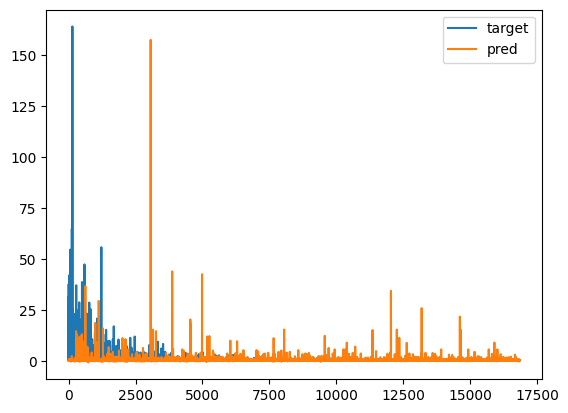

In [34]:
#X_train[['target', 'pred']].reset_index().drop(columns=['index']).sort_index().plot()
X_train['percentage_error'] = (X_train['pred']-X_train['target'])/X_train['target']

<Axes: >

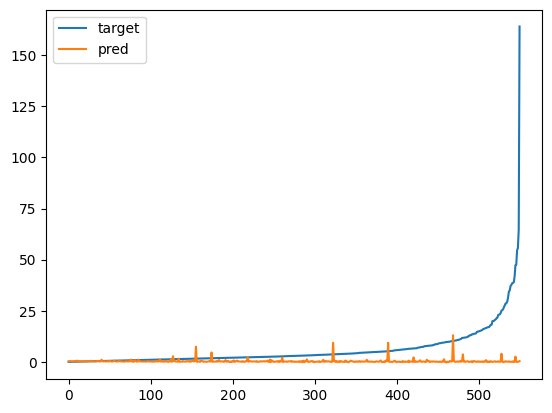

In [47]:
X_train[['target', 'pred']].round(2).groupby('target')['pred'].mean().reset_index().plot()

In [40]:
X_train['percentage_error'].min()

-27542.35953447439